# Compare emissions factors for different processes

In [57]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

colors = ['#d73027', '#91bfdb', '#4575b4', '#fc8d59']
#colors = ['#E66070', '#E6A730', '#6EE588', '#498DE6', '#A055E6']+['pink']

In [155]:
## Inputs
input_path = '/Users/lukecullen/PycharmProjects/petrochemical-data/data/' #../data/'
output_path = '/Users/lukecullen/Library/CloudStorage/OneDrive-UniversityofCambridge/PhD/C-THRU/paper_2_finalisation/figures/'
combined_factors = pd.read_csv(input_path+'combined/processConversionFactors_allgases_allalloc_dedoubled.csv')#processConversionFactors_allgases_allalloc_ammonia.csv')
reduced = combined_factors.copy()#[combined_factors.columns[['sigma' not in i for i in combined_factors.columns]]]
reduced = reduced[reduced['ihs_match']!='PET PELLETS, BOTTLE GRADE (IV 0.82 DL/G) PRODUCTION FROM PET POLYMER MELT BY POLYMETRIX ECOSPHERE SSP']

In [59]:
# Product grouping
product_grouping = pd.read_csv(input_path+'extra_inputs/product_groups.csv', index_col=0)
product_grouping = product_grouping.dropna(subset=['Product group']).reset_index(drop=True)
grouped_emissions = pd.merge(reduced, product_grouping, left_on='Product', right_on='PRODUCT', how='left')

name_matching_ints = {'PROPYLENE, CHEM GRADE':'PROPYLENE', 'PROPYLENE, REFINERY GRADE':'PROPYLENE', 'PROPYLENE, POLYMER GRADE':'PROPYLENE',
 'P-XYLENE':'PARA-XYLENE', 'O-XYLENE':'ORTHO-XYLENE', 'XYLENES, MIXED':'MIXED XYLENES','METHANOL, CRUDE':'METHANOL'}
grouped_emissions['Product'] = grouped_emissions['Product'].replace(name_matching_ints)

fert_names = {'AMMONIA':'AMMONIA', 'AMMONIUM NITRATE FERTILIZER':'AMMONIUM NITRATE', 'HYDROXYLAMMONIUM SULFATE':'AMMONIUM SULPHATE', 'UREA, AGRICULTURAL GRADE':'UREA'}

plastic_names = {'ABS RESIN':'ABS',
                'POLYSTYRENE, EXP': 'EXPANDABLE PS',
                'POLYETHYLENE, HD': 'HDPE', 'POLYETHYLENE, HD POWDERED':'HDPE', 'POLYETHYLENE, HDPE BM':'HDPE',
                'POLYETHYLENE, LD':'LDPE',
                'POLYETHYLENE, LLD':'LLDPE', 'POLYETHYLENE, LLD BM':'LLDPE',
                'PET PELLETS (30% GF)':'PET', 'PET PELLETS (IV=0.6)':'PET', 'PET PELLETS (IV=0.7)':'PET', 'PET PELLETS (IV=0.8)':'PET',  'PET PELLETS (IV=0.82)':'PET', 'PET PELLETS (IV=1.04), SP GRADE':'PET', 'PET PELLETS, GLYCOL MODIFIED':'PET', 'PET POLYMER MELT':'PET',
                'POLYESTER, UNSATURATED':'POLYESTER POLYMER',
                'POLYPROPYLENE':'POLYPROPYLENE',
                'POLYSTYRENE, GP': 'POLYSTYRENE', 'POLYSTYRENE, HI':'POLYSTYRENE',
                'POLYVINYL CHLORIDE':'PVC'
                }

grouped_emissions['Product'] = grouped_emissions['Product'].replace(fert_names)
grouped_emissions['Product'] = grouped_emissions['Product'].replace(plastic_names)
grouped_emissions['Product'] = grouped_emissions['Product'].str.replace(' ', '\n')

In [60]:
def contains_substring(string, substrings):
    for substring in substrings:
        if substring in string:
            return True
    return False


def get_allocation_totals(df:pd.DataFrame, gas:str, allocation:str):
    efs = df[['Product','ihs_match']+list([col for col in df.columns if gas in col and contains_substring(col, stages_used) and allocation in col and 'sigma' not in col])]
    efs['Total'] = efs[efs.columns[2:]].sum(axis=1)
    return efs.dropna(subset=list(efs.columns[2:-1]), how='all')

def filter_df(df, cols, filters):
    for col, filt in zip(cols, filters):
        df = df[[i in filt for i in df[col]]]
    return df

In [61]:
# Sort out misclassified benzene direct process emissions
bzd = filter_df(grouped_emissions, ['PRODUCT'], [['BENZENE']])
bzd['ihs_cradle-to-out-gate CO2e_100a, mass allocation factor'] = bzd['ihs_cradle-to-out-gate CO2e_100a, mass allocation factor']-bzd['Direct Process CO2e_100a, mass allocation factor']
bzd['ihs_cradle-to-out-gate CO2e_100a, mass allocation sigma'] = bzd['ihs_cradle-to-out-gate CO2e_100a, mass allocation sigma']-bzd['Direct Process CO2e_100a, mass allocation sigma']
bzd['Direct Process CO2e_100a, mass allocation factor'], bzd['Direct Process CO2e_100a, mass allocation sigma'] = 0, 0
non_bzd = grouped_emissions[~(grouped_emissions['PRODUCT']=='BENZENE')]
grouped_emissions = pd.concat((non_bzd, bzd)).reset_index(drop=True)

/var/folders/xm/c2mlyq6s23nb_g6_v4fylb7h0000gn/T/ipykernel_16792/447789899.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bzd['ihs_cradle-to-out-gate CO2e_100a, mass allocation factor'] = bzd['ihs_cradle-to-out-gate CO2e_100a, mass allocation factor']-bzd['Direct Process CO2e_100a, mass allocation factor']
/var/folders/xm/c2mlyq6s23nb_g6_v4fylb7h0000gn/T/ipykernel_16792/447789899.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bzd['ihs_cradle-to-out-gate CO2e_100a, mass allocation sigma'] = bzd['ih

# Figure 1 - Difference in processes for individual product

In [62]:
primary_chems = ['AMMONIA', 'BUTADIENE', 'BENZENE', 'ETHYLENE', 'METHANOL', 'PROPYLENE', 'TOLUENE', 'MIXED\nXYLENES', 'PARA-XYLENE']
plastics = ['ABS', 'HDPE', 'LDPE', 'LLDPE', 'PET', 'POLYESTER\nPOLYMER', 'POLYPROPYLENE', 'POLYSTYRENE', 'PVC']#'EXPANDABLE PS',
stages_used = ['Direct Process', 'Feedstock', 'Direct Utilities', 'Indirect Utilities', 'Primary chemicals', 'Organic chemicals', 'Other intermediates']
gas = 'CO2e_100a'

In [63]:
mass_efs = get_allocation_totals(grouped_emissions, gas, 'mass')

ei_vals = grouped_emissions[['Product', 'ei_CO2e_100a_conv_factor']]
cm_vals = grouped_emissions[['Product', 'cm_CO2e_100a_conv_factor']]
ifa_vals = grouped_emissions[['Product', 'ifa_CO2e_100a_CtOG factor']]


## mismatch_corrections
ei_vals.loc[ei_vals[ei_vals['Product']=='PVC'].index, 'ei_CO2e_100a_conv_factor'] = 2.49
ei_vals.loc[ei_vals[ei_vals['Product']=='ABS'].index, 'ei_CO2e_100a_conv_factor'] = 4.48

cm_vals = pd.concat((cm_vals, pd.DataFrame(np.array([['POLYSTYRENE','HDPE', 'LDPE', 'LLDPE'], [2.22, 2.06, 2.49, 2.21]]).transpose(), columns=list(cm_vals.columns))))
cm_vals['cm_CO2e_100a_conv_factor'] = cm_vals['cm_CO2e_100a_conv_factor'].astype(float)

/var/folders/xm/c2mlyq6s23nb_g6_v4fylb7h0000gn/T/ipykernel_16792/3735777062.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  efs['Total'] = efs[efs.columns[2:]].sum(axis=1)


## Figure 4 Ethylene + Methanol

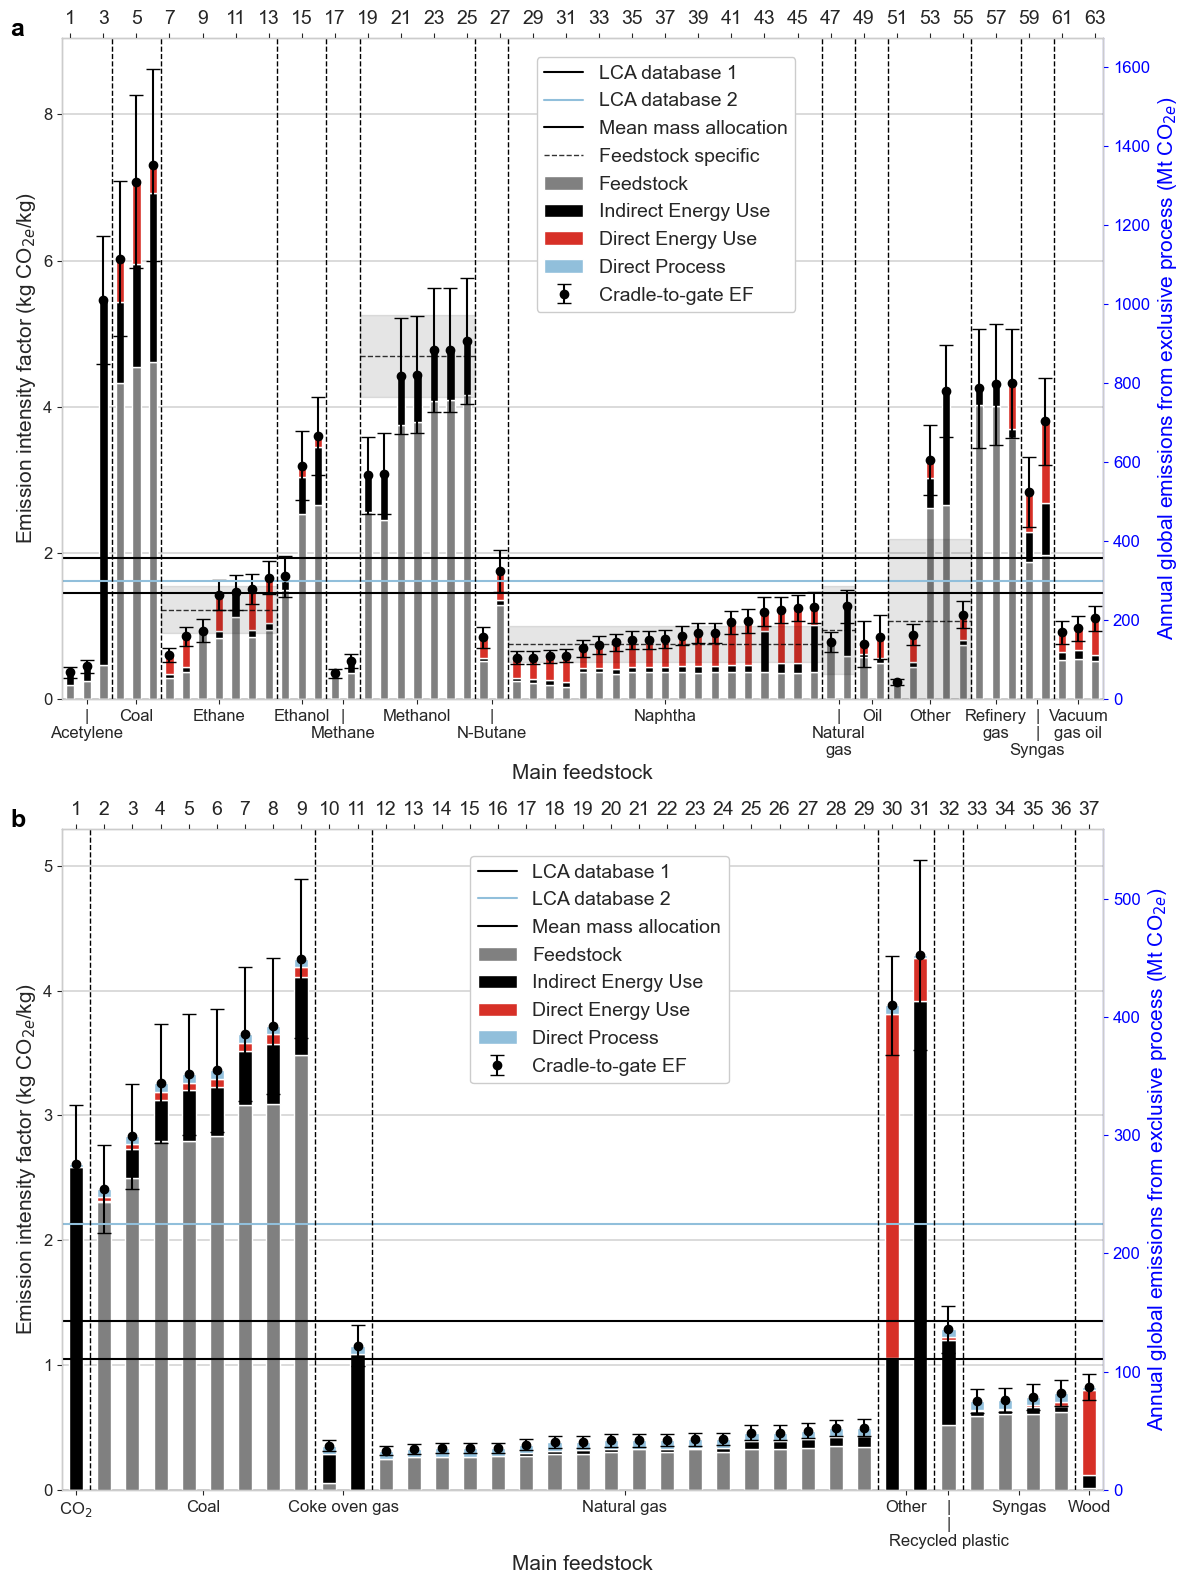

In [172]:
gas = 'CO2e_100a'
plot_product = 'METHANOL'
exclude = 'METHANOL FROM BITUMINOUS COAL'

prod = grouped_emissions[grouped_emissions['Product'] == plot_product]

alloc = 'mass'

total_col = 'ihs_cradle-to-out-gate '+gas+', '+alloc+' allocation '

eth_types = pd.read_csv(input_path+'extra_inputs/ML_cats.csv', index_col=0)
prod_types = prod.merge(eth_types, on='ihs_match').sort_values(['Type', total_col+'factor'], ascending=True)

prod_types = prod_types[prod_types['ihs_match']!=exclude]

total = prod_types[[total_col+'factor', total_col+'sigma']]
properties = stages_used#

breakdown = prod_types[['Type', 'ihs_match']+[prop+' '+gas+', '+alloc+' allocation factor' for prop in properties]].set_index(['Type'])
breakdown.rename(columns=dict(zip([prop+' '+gas+', '+alloc+' allocation factor' for prop in properties], properties)), inplace=True)

breakdown['Feedstock'] = np.sum(breakdown[['Feedstock', 'Primary chemicals', 'Organic chemicals', 'Other intermediates']], axis=1)
properties = ['Feedstock', 'Indirect Utilities', 'Direct Utilities', 'Direct Process']
breakdown = breakdown[['ihs_match']+properties]

breakdown.rename(columns={'Indirect Utilities':'Indirect Energy Use', 'Direct Utilities': 'Direct Energy Use'}, inplace=True)

breakdown = breakdown[breakdown['ihs_match']!=exclude]

#------------------------------------------------#
## Figure start 
fig, axs = plt.subplots(2,1,figsize=[12,16], facecolor='white')

#------------------------------------------------#
## Methanol calcs
gas = 'CO2e_100a'
plot_product = 'METHANOL'
exclude = 'METHANOL FROM BITUMINOUS COAL'

prod = grouped_emissions[grouped_emissions['Product'] == plot_product]

alloc = 'mass'

total_col = 'ihs_cradle-to-out-gate '+gas+', '+alloc+' allocation '

eth_types = pd.read_csv(input_path+'extra_inputs/ML_cats.csv', index_col=0)
prod_types = prod.merge(eth_types, on='ihs_match').sort_values(['Type', total_col+'factor'], ascending=True)

prod_types = prod_types[prod_types['ihs_match']!=exclude]

total = prod_types[[total_col+'factor', total_col+'sigma']]
properties = stages_used#

breakdown = prod_types[['Type', 'ihs_match']+[prop+' '+gas+', '+alloc+' allocation factor' for prop in properties]].set_index(['Type'])
breakdown.rename(columns=dict(zip([prop+' '+gas+', '+alloc+' allocation factor' for prop in properties], properties)), inplace=True)

breakdown['Feedstock'] = np.sum(breakdown[['Feedstock', 'Primary chemicals', 'Organic chemicals', 'Other intermediates']], axis=1)
properties = ['Feedstock', 'Indirect Utilities', 'Direct Utilities', 'Direct Process']
breakdown = breakdown[['ihs_match']+properties]

breakdown.rename(columns={'Indirect Utilities':'Indirect Energy Use', 'Direct Utilities': 'Direct Energy Use'}, inplace=True)

breakdown = breakdown[breakdown['ihs_match']!=exclude]

methanol_breakdown = breakdown.copy()
methanol_total = total.copy()

#------------------------------------------------#
## Methanol plot
# colors = ['#E66070', '#E6A730','#6EE588','#498DE6','#A055E6']+['pink']

eth_production = 105.6
fontsize = 15

plt.rcParams['font.size'] = 12
#sns.set(font_scale=1.5)

ax = axs[1]

ax.set_facecolor('white')
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')

breakdown.plot.bar(stacked=True, ax=ax, alpha=1,color=colors)
ax.grid(False)
ax.grid(which='major', axis='y', linestyle='-', color='k', linewidth=0.2, alpha=1)
ax.set_axisbelow(True)

ax.errorbar(range(len(total)), total[total.columns[0]], yerr=(total.min(axis=1), total[total.columns[1]]), fmt='o', color='black', ecolor='k', capsize=5, label='Cradle-to-gate EF')
ax.axhline(prod['ei_CO2e_100a_conv_factor'].unique(), label='LCA database 1', color=colors[1], alpha=1)
ax.axhline(prod['cm_CO2e_100a_conv_factor'].unique(), label='LCA database 2', color=colors[3], alpha=1)
ax.axhline(1.352086776677054, label='Mean mass allocation', color='k', alpha=1)

ax.set_ylabel('Emission intensity factor (kg CO$_{2e}$/kg)', fontsize=fontsize)
ax.set_xlabel('Main feedstock', fontsize=fontsize)
ax.get_legend().remove()

ax2 = ax.twinx()
ax2.grid(False)
ax2.set_axisbelow(True)
ax2.set_ylabel('Annual global emissions from exclusive process (Mt CO$_{2e}$)', fontsize=fontsize, color='blue')
ax2.tick_params(axis='y', labelcolor='blue', color='blue')
ax2.spines['right'].set_color('blue')

# Set the limits of the secondary y-axis to be a multiple of the primary y-axis
y1_min, y1_max = ax.get_ylim()
y2_min, y2_max = y1_min * eth_production, y1_max * eth_production
ax2.set_ylim(y2_min, y2_max)
#ax.set_title("Emission intensity factors from Ethylene production", fontsize=fontsize+2)

boundaries = [0.5, 8.5, 10.5, 28.5, 30.5, 31.5, 35.5]
ticks = [0, 4.5, 9.5, 19.5,29.5,31,33.5, 36]
tick_labels = ['CO$_{2}$', 'Coal', 'Coke oven gas', 'Natural gas', 'Other', '|\n|\nRecycled plastic','Syngas', 'Wood']#  'Toluene']

ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels, rotation=0)

for location in boundaries:
    ax.axvline(location, color='k', linestyle='--', linewidth=1)

# done=0
# for num, label in enumerate(tick_labels):
#     if label in used_convs.index:
#         value = used_convs.loc[label]['value']
#         err = used_convs.loc[label]['error']
#         ax.plot([boundaries[num-1], boundaries[num]], [value, value], 'k--', linewidth=1, alpha=0.8, label='Feedstock specific' if done==0 else None)
#         done=1
#         ax.fill_between([boundaries[num-1], boundaries[num]], [max(value-err,0), max(value-err,0)], [value+err, value+err], color='k', alpha=0.1)
ax2 = ax.twiny()
ax2.grid(False)
ax2.set_axisbelow(True)
ax2.set_xticks([i+0.5 for i in list(range(0, len(breakdown)))], labels=range(1, len(breakdown)+1), fontsize=fontsize-1)
ax2.set_xlim([0, len(breakdown)])
ax.legend(fontsize=fontsize-1, framealpha=1, fancybox=True, bbox_to_anchor=[0.65,0.6])#loc='upper center')

#------------------------------------------------#
## Ethylene cals
gas = 'CO2e_100a'
plot_product = 'ETHYLENE'
exclude = 'ETHYLENE FROM ATMOSPHERIC GAS OIL BY MILLISECOND(TM) CRACKING/DEMETHANIZATION'

prod = grouped_emissions[grouped_emissions['Product'] == plot_product]

alloc = 'mass'

total_col = 'ihs_cradle-to-out-gate '+gas+', '+alloc+' allocation '

eth_types = pd.read_csv(input_path+'extra_inputs/ethylene_groups.csv', index_col=0)
prod_types = prod.merge(eth_types, on='ihs_match').sort_values(['Type', total_col+'factor'], ascending=True)

prod_types = prod_types[prod_types['ihs_match']!=exclude]

total = prod_types[[total_col+'factor', total_col+'sigma']]
properties = stages_used#

breakdown = prod_types[['Type', 'ihs_match']+[prop+' '+gas+', '+alloc+' allocation factor' for prop in properties]].set_index(['Type'])
breakdown.rename(columns=dict(zip([prop+' '+gas+', '+alloc+' allocation factor' for prop in properties], properties)), inplace=True)

breakdown['Feedstock'] = np.sum(breakdown[['Feedstock', 'Primary chemicals', 'Organic chemicals', 'Other intermediates']], axis=1)
properties = ['Feedstock', 'Indirect Utilities', 'Direct Utilities', 'Direct Process']
breakdown = breakdown[['ihs_match']+properties]

breakdown.rename(columns={'Indirect Utilities':'Indirect Energy Use', 'Direct Utilities': 'Direct Energy Use'}, inplace=True)


breakdown = breakdown[breakdown['ihs_match']!=exclude]

used_convs = pd.read_csv(input_path+'processed/ethylene_conversion_factors.csv')[['Feedstock', 'ihs_cradle-to-out-gate CO2e_100a,  allocation factor', 'ihs_cradle-to-out-gate CO2e_100a,  allocation sigma']].rename(columns={'ihs_cradle-to-out-gate CO2e_100a,  allocation factor':'value', 'ihs_cradle-to-out-gate CO2e_100a,  allocation sigma':'error'})
used_convs['Feedstock'] = used_convs['Feedstock'].str.title().replace({'Lpg':'|\nNatural\ngas', 'Mid-Dist':'Methanol', 'Others':'Other', 'Vacuum':'Vacuum\ngas oil'})
used_convs.set_index('Feedstock', inplace=True)

#------------------------------------------------#
## Ethylene plot
# colors = ['#E66070', '#E6A730','#6EE588','#498DE6','#A055E6']+['pink']

eth_production = 185
fontsize = 15

plt.rcParams['font.size'] = 12
#sns.set(font_scale=1.5)

ax = axs[0]

breakdown.plot.bar(stacked=True, ax=ax, alpha=1,color=colors)

ax.set_facecolor('white')
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
ax.grid(False)
ax.grid(which='major', axis='y', linestyle='-', color='k', linewidth=0.2, alpha=1)
ax.set_axisbelow(True)

ax.errorbar(range(len(total)), total[total.columns[0]], yerr=(total.min(axis=1), total[total.columns[1]]), fmt='o', color='black', ecolor='k', capsize=5, label='Cradle-to-gate EF')
ax.axhline(prod['ei_CO2e_100a_conv_factor'].unique(), label='LCA database 1', color=colors[1], alpha=1)
ax.axhline(prod['cm_CO2e_100a_conv_factor'].unique(), label='LCA database 2', color=colors[3], alpha=1)
ax.axhline(1.931873, label='Mean mass allocation', color='k', alpha=1)

ax.set_ylabel('Emission intensity factor (kg CO$_{2e}$/kg)', fontsize=fontsize)
ax.set_xlabel('Main feedstock', fontsize=fontsize)
ax.get_legend().remove()

ax2 = ax.twinx()
ax2.grid(False)
ax2.set_axisbelow(True)
ax2.set_ylabel('Annual global emissions from exclusive process (Mt CO$_{2e}$)', fontsize=fontsize, color='blue')
ax2.tick_params(axis='y', labelcolor='blue', color='blue')
ax2.spines['right'].set_color('blue')

# Set the limits of the secondary y-axis to be a multiple of the primary y-axis
y1_min, y1_max = ax.get_ylim()
y2_min, y2_max = y1_min * eth_production, y1_max * eth_production
ax2.set_ylim(y2_min, y2_max)
#ax.set_title("Emission intensity factors from Ethylene production", fontsize=fontsize+2)

boundaries = [2.5, 5.5, 12.5, 15.5, 17.5, 24.5, 26.5, 45.5, 47.5, 49.5, 54.5, 57.5, 59.5]
ticks = [1,4,9,14,16.5,21,25.5,36,46.5,48.5,52,56,58.5,61]
tick_labels = ['|\nAcetylene', 'Coal', 'Ethane', 'Ethanol', '|\nMethane', 'Methanol', '|\nN-Butane', 'Naphtha', '|\nNatural\ngas', 'Oil', 'Other', 'Refinery\ngas', '|\n|\nSyngas', 'Vacuum\ngas oil']

ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels, rotation=0)

for location in boundaries:
    ax.axvline(location, color='k', linestyle='--', linewidth=1)

done=0
for num, label in enumerate(tick_labels):
    if label in used_convs.index:
        value = used_convs.loc[label]['value']
        err = used_convs.loc[label]['error']
        ax.plot([boundaries[num-1], boundaries[num]], [value, value], 'k--', linewidth=1, alpha=0.8, label='Feedstock specific' if done==0 else None)
        done=1
        ax.fill_between([boundaries[num-1], boundaries[num]], [max(value-err,0), max(value-err,0)], [value+err, value+err], color='k', alpha=0.1)

ax2 = ax.twiny()
ax2.grid(False)
ax2.set_axisbelow(True)
ax2.set_xticks([i+0.5 for i in list(range(0, len(breakdown), 2))], labels=range(1, len(breakdown)+1, 2), fontsize=fontsize-1)
ax2.set_xlim([0, len(breakdown)])
ax.legend(fontsize=fontsize-1, framealpha=1, fancybox=True, bbox_to_anchor=[0.58,0.57])#loc='upper center')

fs = 18
h = 1.03
w = -0.05
axs[0].text(w, h, 'a', transform = axs[0].transAxes, fontsize=fs, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})

axs[1].text(w, h, 'b', transform = axs[1].transAxes, fontsize=fs, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})

fig.tight_layout()

In [173]:
methanol_breakdown[['Total', 'Total_uct']] = methanol_total.values
methanol_breakdown['Total'] = methanol_breakdown['Total'].round(2)
methanol_breakdown['Total_uct'] = methanol_breakdown['Total_uct'].round(2)
methanol_breakdown.reset_index().to_csv(output_path+'methanol_types.csv')

In [26]:
fig.savefig(output_path+'Figure_4.png', bbox_inches='tight',dpi=300)
fig.savefig(output_path+'Figure_4.eps', format='eps', bbox_inches='tight',dpi=300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [17]:
# colors = ['#E66070', '#E6A730','#6EE588','#498DE6','#A055E6']+['pink']
# 
# eth_production = 50.4
# fontsize = 15
# 
# plt.rcParams['font.size'] = 12
# #sns.set(font_scale=1.5)
# 
# fig, ax = plt.subplots(figsize=[12,8], facecolor='white')
# 
# breakdown.plot.bar(stacked=True, ax=ax, alpha=1,color=colors)
# 
# ax.grid(which='major', axis='y', linestyle='-', color='k', linewidth=0.2, alpha=1)
# ax.set_axisbelow(True)
# 
# ax.errorbar(range(len(total)), total[total.columns[0]], yerr=(total.min(axis=1), total[total.columns[1]]), fmt='o', color='black', ecolor='k', capsize=5, label='Cradle-to-gate EF')
# ax.axhline(prod['ei_CO2e_100a_conv_factor'].unique()[1], label='LCA database 1', color=colors[1], alpha=1)
# ax.axhline(prod['cm_CO2e_100a_conv_factor'].unique()[1], label='LCA database 2', color=colors[2], alpha=1)
# ax.axhline(1.4817977799249484, label='Mean mass allocation', color=colors[3], alpha=1)
# 
# ax.set_ylabel('Emission intensity factor (kg CO$_{2e}$/kg)', fontsize=fontsize)
# ax.set_xlabel('Main feedstock', fontsize=fontsize)
# ax.get_legend().remove()
# 
# ax2 = ax.twinx()
# ax2.set_ylabel('Annual global emissions from exclusive process (Mt CO$_{2e}$)', fontsize=fontsize, color='blue')
# ax2.tick_params(axis='y', labelcolor='blue', color='blue')
# ax2.spines['right'].set_color('blue')
# 
# # Set the limits of the secondary y-axis to be a multiple of the primary y-axis
# y1_min, y1_max = ax.get_ylim()
# y2_min, y2_max = y1_min * eth_production, y1_max * eth_production
# ax2.set_ylim(y2_min, y2_max)
# #ax.set_title("Emission intensity factors from Ethylene production", fontsize=fontsize+2)
# 
# boundaries = [1.5, 3.5, 18.5]
# ticks = [0.5, 2.5, 11.5, 19.5]
# tick_labels = ['Crude', 'Naphtha', 'Xylene reformate', 'Toluene']
# 
# ax.set_xticks(ticks)
# ax.set_xticklabels(tick_labels, rotation=0)
# 
# for location in boundaries:
#     ax.axvline(location, color='k', linestyle='--', linewidth=1)
# 
# # done=0
# # for num, label in enumerate(tick_labels):
# #     if label in used_convs.index:
# #         value = used_convs.loc[label]['value']
# #         err = used_convs.loc[label]['error']
# #         ax.plot([boundaries[num-1], boundaries[num]], [value, value], 'k--', linewidth=1, alpha=0.8, label='Feedstock specific' if done==0 else None)
# #         done=1
# #         ax.fill_between([boundaries[num-1], boundaries[num]], [max(value-err,0), max(value-err,0)], [value+err, value+err], color='k', alpha=0.1)
# ax2 = ax.twiny()
# ax2.set_xticks([i+0.5 for i in list(range(0, len(breakdown)))], labels=range(1, len(breakdown)+1), fontsize=fontsize)
# ax2.set_xlim([0, 21])
# ax.legend(fontsize=fontsize-1, framealpha=1, fancybox=True, bbox_to_anchor=[0.58,0.62])#loc='upper center')
# 
# fig.tight_layout()

## Split emissions plot

In [18]:
gas = 'CO2e_100a'
plot_product = 'ETHYLENE'
exclude = 'ETHYLENE FROM ATMOSPHERIC GAS OIL BY MILLISECOND(TM) CRACKING/DEMETHANIZATION'

prod = grouped_emissions[grouped_emissions['Product'] == plot_product]

alloc = 'mass'

total_col = 'ihs_cradle-to-out-gate '+gas+', '+alloc+' allocation '

eth_types = pd.read_csv(input_path+'extra_inputs/ethylene_groups.csv', index_col=0)
prod_types = prod.merge(eth_types, on='ihs_match').sort_values(['Type', total_col+'factor'], ascending=True)

prod_types = prod_types[prod_types['ihs_match']!=exclude]

total = prod_types[[total_col+'factor', total_col+'sigma']]
properties = stages_used#

breakdown = prod_types[['Type', 'ihs_match']+[prop+' '+gas+', '+alloc+' allocation factor' for prop in properties]].set_index(['Type'])
breakdown.rename(columns=dict(zip([prop+' '+gas+', '+alloc+' allocation factor' for prop in properties], properties)), inplace=True)

breakdown['Feedstock'] = np.sum(breakdown[['Feedstock', 'Primary chemicals', 'Organic chemicals', 'Other intermediates']], axis=1)
properties = ['Feedstock', 'Indirect Utilities', 'Direct Utilities', 'Direct Process']
breakdown = breakdown[['ihs_match']+properties]

breakdown.rename(columns={'Indirect Utilities':'Indirect Energy Use', 'Direct Utilities': 'Direct Energy Use'}, inplace=True)


breakdown = breakdown[breakdown['ihs_match']!=exclude]

In [19]:
breakdown['ihs_match'].reset_index().to_csv('C:/Users\lukec\PycharmProjects\petrochemical-data/analysis_outputs/eth_numbers.csv')

OSError: Cannot save file into a non-existent directory: 'C:/Users\lukec\PycharmProjects\petrochemical-data/analysis_outputs'

In [9]:
breakdown.reset_index().fillna(0).drop(columns=['ihs_match']).reset_index().merge(total.reset_index(drop=True).reset_index(), on='index').drop(columns=['index']).rename(columns={'ihs_cradle-to-out-gate CO2e_100a, mass allocation factor':'Total', 'ihs_cradle-to-out-gate CO2e_100a, mass allocation sigma':'Total uncertainty'}).to_csv('C:/Users\lukec\PycharmProjects\petrochemical-data/analysis_outputs\data_tables/fig4.csv')

In [20]:
used_convs = pd.read_csv(input_path+'processed/ethylene_conversion_factors.csv')[['Feedstock', 'ihs_cradle-to-out-gate CO2e_100a,  allocation factor', 'ihs_cradle-to-out-gate CO2e_100a,  allocation sigma']].rename(columns={'ihs_cradle-to-out-gate CO2e_100a,  allocation factor':'value', 'ihs_cradle-to-out-gate CO2e_100a,  allocation sigma':'error'})
used_convs['Feedstock'] = used_convs['Feedstock'].str.title().replace({'Lpg':'|\nNatural\ngas', 'Mid-Dist':'Methanol', 'Others':'Other', 'Vacuum':'Vacuum\ngas oil'})
used_convs.set_index('Feedstock', inplace=True)

In [154]:
# Save output plot
fig.savefig(output_path+'ethylene_breakdown.png', bbox_inches='tight', dpi=150)

## SI - Split emissions for other Chems

In [65]:
production_file = input_path+'processed/icisFacilityProduction_w_uncertainties.csv'
production_facils = pd.read_csv(production_file, index_col=0)
production = production_facils.groupby(['PRODUCT']).sum().reset_index().drop(columns=['#', 'START_YR', 'LATITUDE', 'LONGITUDE'])[['PRODUCT', '2020']]

In [66]:
ifa_prod = pd.read_csv(input_path+'/extracted/IFA_production_w_uncertainties.csv')[['PRODUCT', '2020']].groupby(
    'PRODUCT').sum().reset_index()

name_conversions = {
    'NH3': 'AMMONIA',
    'AN': 'AMMONIUM NITRATE',
    'Ammonium nitrate (33.5-0-0) granulated': 'AMMONIUM NITRATE',
    'AS': 'AMMONIUM SULPHATE',
    'CAN': 'CALCIUM AMMONIUM NITRATE',
    'Calcium ammonium nitrate (27-0-0)': 'CALCIUM AMMONIUM NITRATE',
    'Urea (46-0-0)': 'UREA'
}

ifa_prod['PRODUCT'] = ifa_prod['PRODUCT'].replace(name_conversions)

total_prod = pd.concat((production, ifa_prod)).sort_values('PRODUCT').reset_index(drop=True)


/var/folders/xm/c2mlyq6s23nb_g6_v4fylb7h0000gn/T/ipykernel_16792/3279260267.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breakdown.rename(columns=dict(zip([prop+' '+gas+', '+alloc+' allocation factor' for prop in properties], properties)), inplace=True)
/var/folders/xm/c2mlyq6s23nb_g6_v4fylb7h0000gn/T/ipykernel_16792/3279260267.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breakdown['Feedstock'] = np.sum(breakdown[['Feedstock', 'Primary chemicals', 'Organic chemicals', 'Other intermediates']], axis=1)


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users\\lukec\\PycharmProjects\\petrochemical-data/analysis_outputs\\conversionFactors_SI/plastics/AMMONIA.png'

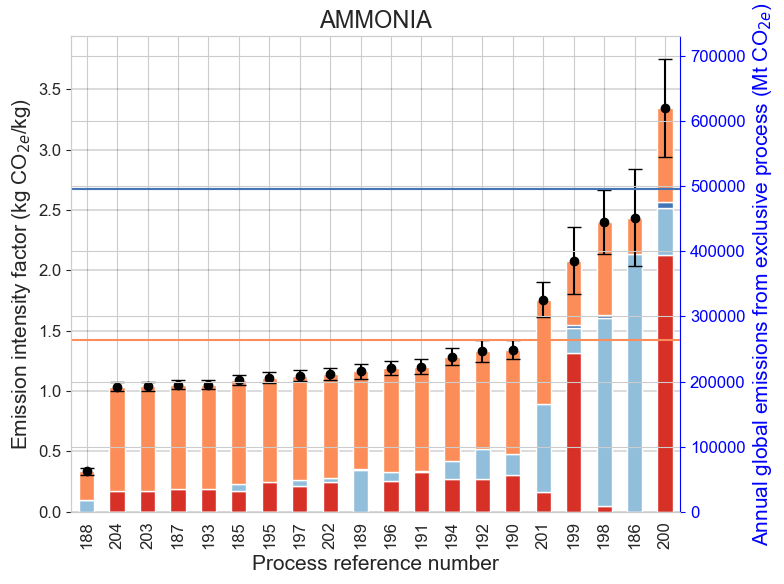

In [67]:
gas = 'CO2e_100a'

primary_chems = ['AMMONIA', 'BUTADIENE', 'BENZENE', 'ETHYLENE', 'METHANOL']#, 'PROPYLENE', 'TOLUENE', 'MIXED\nXYLENES', 'PARA-XYLENE']
plastics = ['ABS', 'HDPE', 'LDPE', 'LLDPE', 'PET', 'POLYESTER\nPOLYMER', 'POLYPROPYLENE', 'POLYSTYRENE', 'PVC']#'EXPANDABLE PS',

for plot_product in primary_chems:
    #plot_product = 'PROPYLENE'
    # exclude = 'ETHYLENE FROM ATMOSPHERIC GAS OIL BY MILLISECOND(TM) CRACKING/DEMETHANIZATION'

    prod = grouped_emissions[grouped_emissions['Product'] == plot_product].sort_values([total_col+'factor'], ascending=True)
    alloc = 'mass'
    total_col = 'ihs_cradle-to-out-gate '+gas+', '+alloc+' allocation '

    #eth_types = pd.read_csv(input_path+'extra_inputs/ethylene_groups.csv', index_col=0)
    # prod_types = prod.merge(eth_types, on='ihs_match').sort_values(['Type', total_col+'factor'], ascending=True)
    #
    # prod_types = prod_types[prod_types['ihs_match']!=exclude]

    total = prod[[total_col+'factor', total_col+'sigma']]
    properties = stages_used#

    breakdown = prod[['ihs_match']+[prop+' '+gas+', '+alloc+' allocation factor' for prop in properties]]#.set_index(['Type'])
    breakdown.rename(columns=dict(zip([prop+' '+gas+', '+alloc+' allocation factor' for prop in properties], properties)), inplace=True)

    # breakdown['Feedstock'] = np.sum(breakdown[['Feedstock', 'Primary chemicals', 'Organic chemicals', 'Other intermediates']], axis=1)
    # properties = ['Feedstock', 'Indirect Utilities', 'Direct Utilities', 'Direct Process']

    breakdown['Feedstock'] = np.sum(breakdown[['Feedstock', 'Primary chemicals', 'Organic chemicals', 'Other intermediates']], axis=1)
    properties = ['Feedstock', 'Indirect Utilities', 'Direct Utilities', 'Direct Process']#, 'Primary chemicals', 'Organic chemicals', 'Other intermediates']

    breakdown = breakdown[['ihs_match']+properties]

    breakdown.rename(columns={'Indirect Utilities':'Indirect Energy Use', 'Direct Utilities': 'Direct Energy Use'}, inplace=True)
    breakdown.dropna(subset=['ihs_match'], inplace=True)

    product_production = total_prod[total_prod['PRODUCT']==plot_product.replace('\n',' ')]['2020'].values
    fontsize = 15
    plt.rcParams['font.size'] = 12
    #sns.set(font_scale=1.5)

    fig, ax = plt.subplots(figsize=[int(3+np.ceil(len(prod)/4)), 6],facecolor='white')

    breakdown.plot.bar(stacked=True, ax=ax, alpha=1,color=colors)

    ax.grid(which='major', axis='y', linestyle='-', color='k', linewidth=0.2, alpha=1)
    ax.set_axisbelow(True)

    ax.errorbar(range(len(total)), total[total.columns[0]], yerr=(total.min(axis=1), total[total.columns[1]]), fmt='o', color='black', ecolor='k', capsize=5, label='Cradle-to-gate EF')
    if prod['ei_CO2e_100a_conv_factor'].dropna().unique() != np.NAN:
        ax.axhline(prod['ei_CO2e_100a_conv_factor'].dropna().unique(), label='LCA database 1', color=colors[1], alpha=1)
    if prod['cm_CO2e_100a_conv_factor'].dropna().unique() != np.NAN:
        ax.axhline(prod['cm_CO2e_100a_conv_factor'].dropna().unique(), label='LCA database 2', color=colors[2], alpha=1)
    ax.axhline(total[total.columns[0]].mean(), label='Mean mass allocation', color=colors[3], alpha=1)

    ax.set_ylabel('Emission intensity factor (kg CO$_{2e}$/kg)', fontsize=fontsize)
    ax.set_xlabel('Process reference number', fontsize=fontsize)
    ax.get_legend().remove()
    #
    ax2 = ax.twinx()
    ax2.set_ylabel('Annual global emissions from exclusive process (Mt CO$_{2e}$)', fontsize=fontsize, color='blue')
    ax2.tick_params(axis='y', labelcolor='blue', color='blue')
    ax2.spines['right'].set_color('blue')
    #
    # Set the limits of the secondary y-axis to be a multiple of the primary y-axis
    y1_min, y1_max = ax.get_ylim()
    y2_min, y2_max = y1_min * product_production, y1_max * product_production
    ax2.set_ylim(y2_min, y2_max)
    ax.set_title(plot_product, fontsize=fontsize+2)

    #ax.legend(fontsize=fontsize-1, framealpha=1, fancybox=True, bbox_to_anchor=[0,-0.1],ncol=4)

    fig.tight_layout()

    fig.savefig('C:/Users\lukec\PycharmProjects\petrochemical-data/analysis_outputs\conversionFactors_SI/plastics/'+plot_product.replace('\n','_')+'.png', bbox_inches='tight', dpi=200)

In [103]:
fig.savefig('C:/Users\lukec\PycharmProjects\petrochemical-data/analysis_outputs\conversionFactors_SI/legend.png', bbox_inches='tight', dpi=300)

In [8]:
colors = ['#E66070', '#E6A730','#6EE588','#498DE6','#A055E6']+['pink']

product_production = production[production['PRODUCT']==plot_product]['2020'].values
fontsize = 15
plt.rcParams['font.size'] = 12
#sns.set(font_scale=1.5)

fig, ax = plt.subplots(figsize=[12,8], facecolor='white')

breakdown.plot.bar(stacked=True, ax=ax, alpha=1,color=colors)

ax.grid(which='major', axis='y', linestyle='-', color='k', linewidth=0.2, alpha=1)
ax.set_axisbelow(True)

ax.errorbar(range(len(total)), total[total.columns[0]], yerr=(total.min(axis=1), total[total.columns[1]]), fmt='o', color='black', ecolor='k', capsize=5, label='Cradle-to-gate EF')
if prod['ei_CO2e_100a_conv_factor'].dropna().unique() != np.NAN:
    ax.axhline(prod['ei_CO2e_100a_conv_factor'].dropna().unique(), label='LCA database 1', color=colors[1], alpha=1)
if prod['cm_CO2e_100a_conv_factor'].dropna().unique() != np.NAN:
    ax.axhline(prod['cm_CO2e_100a_conv_factor'].dropna().unique(), label='LCA database 2', color=colors[2], alpha=1)
ax.axhline(total[total.columns[0]].mean(), label='Mean mass allocation', color=colors[3], alpha=1)

ax.set_ylabel('Emission intensity factor (kg CO$_{2e}$/kg)', fontsize=fontsize)
ax.set_xlabel('Main feedstock', fontsize=fontsize)
ax.get_legend().remove()
#
ax2 = ax.twinx()
ax2.set_ylabel('Annual global emissions from exclusive process (Mt CO$_{2e}$)', fontsize=fontsize, color='blue')
ax2.tick_params(axis='y', labelcolor='blue', color='blue')
ax2.spines['right'].set_color('blue')
#
# Set the limits of the secondary y-axis to be a multiple of the primary y-axis
y1_min, y1_max = ax.get_ylim()
y2_min, y2_max = y1_min * product_production, y1_max * product_production
ax2.set_ylim(y2_min, y2_max)
ax.set_title(plot_product, fontsize=fontsize+2)

ax.legend(fontsize=fontsize-1, framealpha=1, fancybox=True, loc='upper left')

fig.tight_layout()

NameError: name 'production' is not defined

In [152]:
pvc = grouped_emissions[grouped_emissions['Product'] == 'PVC']
pvc['Organic chemicals CO2e_100a, mass allocation factor'] = pvc['Feedstock CO2e_100a, mass allocation factor']
pvc['Organic chemicals CO2e_100a, mass allocation sigma'] = pvc['Feedstock CO2e_100a, mass allocation sigma']

pvc['Feedstock CO2e_100a, mass allocation factor'] = 0
pvc['Feedstock CO2e_100a, mass allocation sigma'] = 0

grouped_emissions = pd.concat((grouped_emissions[grouped_emissions['Product'] != 'PVC'], pvc))

/var/folders/xm/c2mlyq6s23nb_g6_v4fylb7h0000gn/T/ipykernel_16792/3291412396.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pvc['Organic chemicals CO2e_100a, mass allocation factor'] = pvc['Feedstock CO2e_100a, mass allocation factor']
/var/folders/xm/c2mlyq6s23nb_g6_v4fylb7h0000gn/T/ipykernel_16792/3291412396.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pvc['Organic chemicals CO2e_100a, mass allocation sigma'] = pvc['Feedstock CO2e_100a, mass allocation sigma']
/var/folders/xm/c2mlyq6s23nb_g6_v4

In [176]:
grouped_emissions = grouped_emissions[grouped_emissions['ihs_match'] != 'AMMONIA FROM SUBBITUMINOUS COAL BY SHELL GASIFIER']

/var/folders/xm/c2mlyq6s23nb_g6_v4fylb7h0000gn/T/ipykernel_16792/279190629.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breakdown.rename(columns=dict(zip([prop+' '+gas+', '+alloc+' allocation factor' for prop in properties], properties)), inplace=True)
/var/folders/xm/c2mlyq6s23nb_g6_v4fylb7h0000gn/T/ipykernel_16792/279190629.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breakdown['Intermediates'] = np.sum(breakdown[['Organic chemicals', 'Other intermediates']], axis=1)
/var/folders/xm/c2mlyq6s23nb_g6_v4fylb7h0000gn/T/ipykernel_16792/279190629.py:6

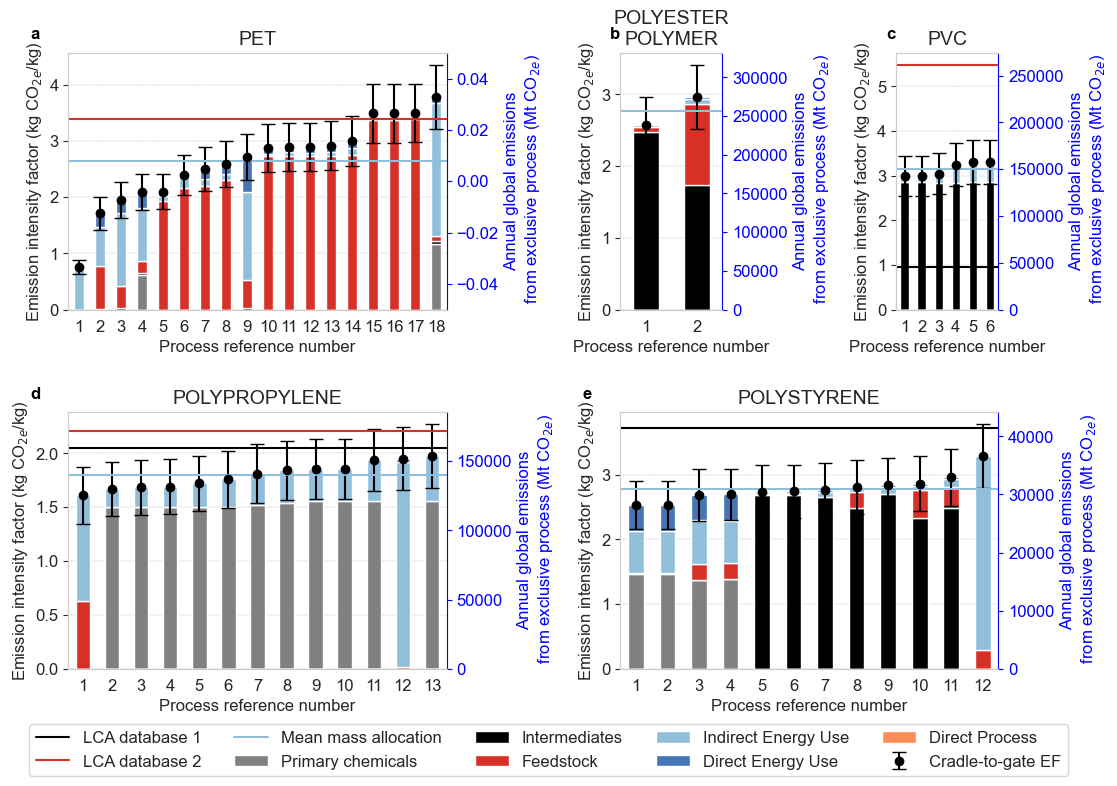

In [213]:
## First plot - Ammonia, benzene, butadiene, mixed xylenes
gas = 'CO2e_100a'
fontsize = 11

#colors = ['#d73027', '#91bfdb', '#4575b4', '#fc8d59']
colors = ['grey', 'k']+['#d73027', '#91bfdb', '#4575b4', '#fc8d59']

primary_chems = ['PET', 'POLYESTER\nPOLYMER', 'PVC', 'POLYPROPYLENE', 'POLYSTYRENE']#['ABS', 'HDPE', 'LDPE', 'LLDPE']##['PARA-XYLENE', 'TOLUENE', 'PROPYLENE']#['AMMONIA', 'BENZENE', 'BUTADIENE', 'MIXED\nXYLENES']###

# fig, axs = plt.subplots(2, 2, figsize=[12, 8], facecolor='white')
# axs = axs.flatten()

fig = plt.figure(figsize=[12, 8], facecolor='white')
# axs = [plt.subplot2grid((2, 2), (0, 0)), plt.subplot2grid((2, 2), (0, 1)), plt.subplot2grid((2, 2), (1, 0), colspan=2)]
# axs = [plt.subplot2grid((2, 3), (0, 0)), plt.subplot2grid((2, 3), (0, 1), colspan=2), plt.subplot2grid((2, 3), (1, 0)), plt.subplot2grid((2, 3), (1, 1), colspan=2)]
axs = [plt.subplot2grid((2, 4), (0, 0), colspan=2), plt.subplot2grid((2, 4), (0, 2)), plt.subplot2grid((2, 4), (0, 3)), plt.subplot2grid((2, 4), (1, 0), colspan=2), plt.subplot2grid((2, 4), (1, 2), colspan=2)]

for ax, plot_product in zip(axs, primary_chems):
    #plot_product = 'PROPYLENE'
    # exclude = 'ETHYLENE FROM ATMOSPHERIC GAS OIL BY MILLISECOND(TM) CRACKING/DEMETHANIZATION'

    prod = grouped_emissions[grouped_emissions['Product'] == plot_product].sort_values([total_col+'factor'], ascending=True)
    alloc = 'mass'
    total_col = 'ihs_cradle-to-out-gate '+gas+', '+alloc+' allocation '

    #eth_types = pd.read_csv(input_path+'extra_inputs/ethylene_groups.csv', index_col=0)
    # prod_types = prod.merge(eth_types, on='ihs_match').sort_values(['Type', total_col+'factor'], ascending=True)
    #
    # prod_types = prod_types[prod_types['ihs_match']!=exclude]

    total = prod[[total_col+'factor', total_col+'sigma']]
    properties = stages_used#

    breakdown = prod[['ihs_match']+[prop+' '+gas+', '+alloc+' allocation factor' for prop in properties]]#.set_index(['Type'])
    breakdown.rename(columns=dict(zip([prop+' '+gas+', '+alloc+' allocation factor' for prop in properties], properties)), inplace=True)

    # breakdown['Feedstock'] = np.sum(breakdown[['Feedstock', 'Primary chemicals', 'Organic chemicals', 'Other intermediates']], axis=1)
    # properties = ['Feedstock', 'Indirect Utilities', 'Direct Utilities', 'Direct Process']
    # 
    breakdown['Intermediates'] = np.sum(breakdown[['Organic chemicals', 'Other intermediates']], axis=1)
    properties = ['Primary chemicals', 'Intermediates', 'Feedstock', 'Indirect Utilities', 'Direct Utilities', 'Direct Process']

    breakdown = breakdown[['ihs_match']+properties]

    breakdown.rename(columns={'Indirect Utilities':'Indirect Energy Use', 'Direct Utilities': 'Direct Energy Use'}, inplace=True)
    breakdown.dropna(subset=['ihs_match'], inplace=True)

    product_production = total_prod[total_prod['PRODUCT']==plot_product.replace('\n',' ')]['2020'].values
    fontsize = 12
    plt.rcParams['font.size'] = 12
    #sns.set(font_scale=1.5)

    breakdown.reset_index(drop=True, inplace=True)
    breakdown.index = breakdown.index+1
    bd = breakdown.plot.bar(stacked=True, ax=ax, alpha=1, color=colors)

    ax.grid(False)
    ax.grid(which='major', axis='y', linestyle='--', color='k', linewidth=0.2, alpha=0.5)
    ax.set_axisbelow(True)

    ax.errorbar(range(len(total)), total[total.columns[0]], yerr=(total.min(axis=1), total[total.columns[1]]), fmt='o', color='black', ecolor='k', capsize=5, label='Cradle-to-gate EF')
    if prod['ei_CO2e_100a_conv_factor'].dropna().unique() != np.NAN:
        ax.axhline(prod['ei_CO2e_100a_conv_factor'].dropna().unique(), label='LCA database 1', color=colors[1], alpha=1)
    if prod['cm_CO2e_100a_conv_factor'].dropna().unique() != np.NAN:
        ax.axhline(prod['cm_CO2e_100a_conv_factor'].dropna().unique(), label='LCA database 2', color=colors[2], alpha=1)
    ax.axhline(total[total.columns[0]].mean(), label='Mean mass allocation', color=colors[3], alpha=1)

    ax.set_ylabel('Emission intensity factor (kg CO$_{2e}$/kg)', fontsize=fontsize)
    ax.set_xlabel('Process reference number', fontsize=fontsize)
    ax.get_legend().remove()
    #
    ax2 = ax.twinx()
    ax2.grid(False)
    ax2.set_ylabel('Annual global emissions\n from exclusive process (Mt CO$_{2e}$)', fontsize=fontsize, color='blue')
    ax2.tick_params(axis='y', labelcolor='blue', color='blue')
    ax2.spines['right'].set_color('blue')
    #
    # Set the limits of the secondary y-axis to be a multiple of the primary y-axis
    y1_min, y1_max = ax.get_ylim()
    y2_min, y2_max = y1_min * product_production, y1_max * product_production
    ax2.set_ylim(y2_min, y2_max)
    ax.set_title(plot_product, fontsize=fontsize+2)
    
    # Rotate x axis labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    
w, h = -0.1, 1.1
axs[0].text(w, h, 'a', transform = axs[0].transAxes, fontsize=fontsize, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})
axs[1].text(w, h, 'b', transform = axs[1].transAxes, fontsize=fontsize, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})
axs[2].text(w, h, 'c', transform = axs[2].transAxes, fontsize=fontsize, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})

if len(axs) > 3:
    axs[3].text(w, h, 'd', transform = axs[3].transAxes, fontsize=fontsize, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})

if len(axs) > 4:
    axs[4].text(w, h, 'e', transform = axs[4].transAxes, fontsize=fontsize, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})


plt.subplots_adjust(hspace=0.4, wspace=1.7) 
#axs[2].legend(loc='lower center', bbox_to_anchor=(1.27, -0.45), ncol=4)
#axs[0].legend(loc='lower center', bbox_to_anchor=(1.27, -1.95), ncol=4)
#axs[2].legend(loc='lower center', bbox_to_anchor=(2.57, -0.45), ncol=5)
axs[3].legend(loc='lower center', bbox_to_anchor=(1.27, -0.45), ncol=5)

    #ax.legend(fontsize=fontsize-1, framealpha=1, fancybox=True, bbox_to_anchor=[0,-0.1], ncol=4)

    # fig.savefig('C:/Users\lukec\PycharmProjects\petrochemical-data/analysis_outputs\conversionFactors_SI/plastics/'+plot_product.replace('\n','_')+'.png', bbox_inches='tight', dpi=200)

In [214]:
fig.savefig(output_path+'Figure_S8.png', bbox_inches='tight',dpi=300)
fig.savefig(output_path+'Figure_S8.eps', format='eps', bbox_inches='tight',dpi=300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [215]:
# pcs = ['AMMONIA', 'BENZENE', 'BUTADIENE', 'MIXED\nXYLENES', 'PARA-XYLENE', 'TOLUENE', 'PROPYLENE']
pcs = ['ABS', 'HDPE', 'LDPE', 'LLDPE', 'PET', 'POLYESTER\nPOLYMER', 'PVC', 'POLYPROPYLENE', 'POLYSTYRENE']

output = grouped_emissions.sort_values(['Product', 'ihs_cradle-to-out-gate CO2e_100a, mass allocation factor'])[['Product', 'ihs_match', 'ihs_cradle-to-out-gate CO2e_100a, mass allocation factor', 'ihs_cradle-to-out-gate CO2e_100a, mass allocation sigma']]
output.rename(columns={'ihs_match':'Process', 'ihs_cradle-to-out-gate CO2e_100a, mass allocation factor':'Total', 'ihs_cradle-to-out-gate CO2e_100a, mass allocation sigma':'Uncertainty'}, inplace=True)
output = output[output['Product'].isin(pcs)]
output['Total'] = output['Total'].round(2)
output['Uncertainty'] = output['Uncertainty'].round(2)

# Have a column called number that goes from 1 to number of rows of each product type
output['Number'] = output.groupby('Product').cumcount()+1
output.to_csv(output_path+'plastics_numbers.csv')

## Box plot with production

In [ ]:
# # Import packages
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
#
# ## Inputs
# input_path = '../data/'
# output_path = '../analysis_outputs/'
# combined_factors = pd.read_csv(input_path+'combined/processConversionFactors_w_elec_allgases_allalloc.csv')
# reduced = combined_factors.copy()#[combined_factors.columns[['sigma' not in i for i in combined_factors.columns]]]
#
# # Product grouping
# product_grouping = pd.read_csv(input_path+'extra_inputs/product_groups.csv', index_col=0)
# product_grouping = product_grouping.dropna(subset=['Product group']).reset_index(drop=True)
# grouped_emissions = pd.merge(reduced, product_grouping, left_on='Product', right_on='PRODUCT', how='left')
#
# # Conversion factor plot
#
# ## Inputs
# gas = 'CO2e_100a'
# ihs_property = 'ihs_cradle-to-out-gate '
# allocations = ['mass', 'energy', 'economic']
# take_chemicals = ['ACETIC ACID', 'ACRYLONITRILE', 'AMMONIA', 'POLYPROPYLENE', 'PROPYLENE OXIDE', 'ETHYLENE', 'BUTADIENE', 'BENZENE', 'TOLUENE', 'METHYL METHACRYLATE', 'NYLON 6 CHIPS', 'NYLON 66 RESIN', 'P-XYLENE', 'POLYETHYLENE TEREPHTHALATE', 'POLYETHYLENE, llD', 'POLYETHYLENE, LD', 'UREA']#False
# sample_size = 100
# plt.rcParams.update({'font.size': 12})
#
# ## Get appropriate data
# pe = grouped_emissions.copy()
# pe = pe[['Product','ihs_match']+list(pe.columns[[gas in col for col in pe.columns]])]
#
# if take_chemicals:
#     pe = pe[[i in take_chemicals for i in pe['Product']]]
#     fig, axs = plt.subplots(1,1, figsize=[9,8], facecolor='white')
# else: fig, axs = plt.subplots(1,1, figsize=[10,50], facecolor='white')
#
# ## Loop over allocation types for averages and scatter
# ihs_vals = pd.DataFrame()
# ## Plot IHS values
# for i, (alloc, color) in enumerate(zip(allocations, ['C1', 'C3', 'C4'])):
#
#     column = ihs_property+gas+', '+alloc+' allocation factor'
#     alloc_df = pe[['Product', 'ihs_match', column]].rename(columns={column:'conv_factor'})
#     alloc_df['Allocation'] = alloc
#     ihs_vals = pd.concat((ihs_vals, alloc_df))
#     globals()[alloc+'avg'] = pe.groupby('Product').mean()[column]
#
#     alloc_data = ihs_vals[ihs_vals['Allocation'] == alloc]
#     height_dict = dict(zip(alloc_data['Product'].unique(), range(len(alloc_data['Product'].unique()))))
#
#     axs.scatter(alloc_data['conv_factor'], alloc_data['Product'].replace(height_dict)-0.15+(i*0.15), color=color, s=2, label=alloc.title() +' allocations')
#     axs.scatter(globals()[alloc+'avg'], np.arange(0, len(alloc_data['Product'].unique()))-0.15+(i*0.15), color=color, s=50, marker=(5, 1), label=alloc.title() +' allocation mean')
#
# ## Get single values
# ihs_mins = ihs_vals.groupby('Product').min()['conv_factor']
# ihs_maxs = ihs_vals.groupby('Product').max()['conv_factor']
# cm_vals = pe.groupby('Product').max()['cm_'+gas+'_conv_factor']
# ei_vals = pe.groupby('Product').max()['ei_'+gas+'_conv_factor']
# if gas == 'CO2e_100a':
#     ifa_vals = pe.groupby('Product').max()['ifa_'+gas+'_CtOG factor']
#
# ## Plot CM & EI values
# axs.scatter(cm_vals, np.arange(0, len(cm_vals)), color='c', label='Carbon Minds values')
# axs.scatter(ei_vals, np.arange(0, len(cm_vals)), color='g', label='EcoInvent values')
# if gas == 'CO2e_100a':
#     axs.scatter(ifa_vals, np.arange(0, len(cm_vals)), color='b', label='IFA values')
#
# merged_limits = ihs_mins.reset_index().merge(ei_vals.reset_index()).merge(cm_vals.reset_index()).merge(ifa_vals.reset_index()).merge(ihs_maxs.reset_index().rename(columns={'conv_factor':'maxs'}))
#
# axs.barh(ihs_mins.index.values, merged_limits.max(axis=1)-merged_limits.min(axis=1), left=merged_limits.min(axis=1), color='C1', alpha=0.15, label='Range of EFs')
#
#
# fontsize = 14
# axs.set_title('Petrochemical production emission intensity factors', fontsize=fontsize+2)
# axs.invert_yaxis()
# axs.set_xscale('symlog')
# axs.set_xlim([-0.2, 30])
# axs.set_xlabel('Emission intensity factor (kg CO$_{2eq}$ / kg product)', fontsize=fontsize)
# axs.grid(which='both', axis='both', linestyle='--', linewidth=0.5)
# axs.legend(bbox_to_anchor=(1.01, 0.75), fontsize=fontsize)